# Langmuir Isotherm: DOE-Driven Active Learning

This notebook demonstrates a complete **Design of Experiments (DOE)** workflow with
**active learning** to efficiently estimate the parameters of a known model — the
Langmuir adsorption isotherm:

$$q = \frac{q_{\max} \, K \, P}{1 + K \, P}$$

where:
- $q$ — amount adsorbed (mol/g)
- $q_{\max}$ — monolayer saturation capacity
- $K$ — equilibrium adsorption constant (1/bar)
- $P$ — partial pressure (bar)

## Workflow

1. **Initial Design** — Generate a small Latin Hypercube design
2. **Simulate Experiments** — Measure `q` at designed pressures (replace with real lab data)
3. **Fit Langmuir Model** — Using parametric basis functions
4. **Evaluate & Diagnose** — Residuals, parity plot, coefficient intervals
5. **Active Learning Loop** — Suggest the most informative next experiments, collect data, refit
6. **Final ANOVA** — Decompose variance to confirm model adequacy
7. **Report** — Extract parameters, uncertainty, and LaTeX equation

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from jaxsr import (
    AdaptiveSampler,
    BasisLibrary,
    DOEStudy,
    SymbolicRegressor,
    anova,
    bootstrap_coefficients,
    bootstrap_predict,
)

np.random.seed(42)
print("Setup complete.")

Setup complete.


## Ground Truth (for simulation)

In a real study you would not know these values — they are what you are trying to
discover. Here we define them so we can simulate "running experiments" and verify
that the method recovers the true parameters.

| Parameter | True Value | Units |
|-----------|-----------|-------|
| $q_{\max}$ | 5.0 | mol/g |
| $K$ | 2.0 | 1/bar |
| Noise $\sigma$ | 0.15 | mol/g |

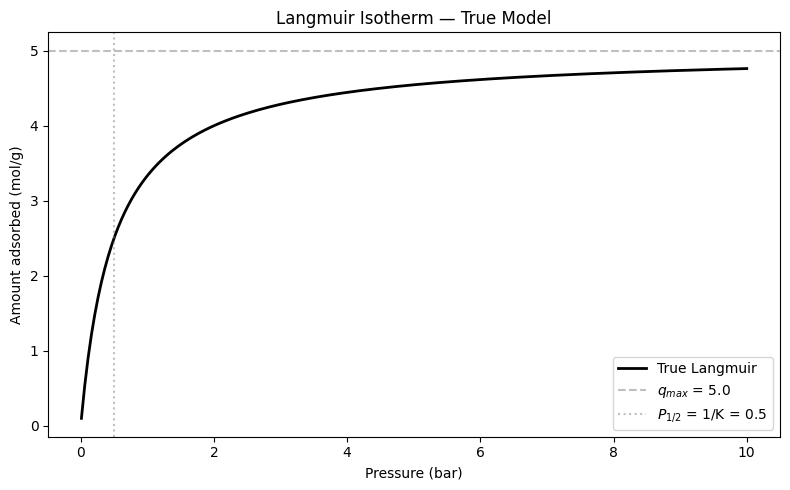

In [2]:
# True Langmuir parameters (unknown to the experimenter)
Q_MAX_TRUE = 5.0   # mol/g
K_TRUE = 2.0       # 1/bar
NOISE_STD = 0.15   # measurement noise

# Pressure range for the study
P_BOUNDS = [(0.01, 10.0)]  # bar


def run_experiment(P_values):
    """Simulate running adsorption experiments.

    Replace this function with actual lab measurements in a real study.
    Loadings are clipped to zero (adsorption cannot be negative).
    """
    P = np.asarray(P_values).flatten()
    q_true = Q_MAX_TRUE * K_TRUE * P / (1 + K_TRUE * P)
    q_measured = q_true + NOISE_STD * np.random.randn(len(P))
    return np.maximum(q_measured, 0.0)  # Adsorption cannot be negative


# Visualize the true isotherm
P_dense = np.linspace(0.01, 10.0, 200)
q_dense = Q_MAX_TRUE * K_TRUE * P_dense / (1 + K_TRUE * P_dense)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(P_dense, q_dense, "k-", linewidth=2, label="True Langmuir")
ax.axhline(Q_MAX_TRUE, color="gray", linestyle="--", alpha=0.5, label=f"$q_{{max}}$ = {Q_MAX_TRUE}")
ax.axvline(1.0 / K_TRUE, color="gray", linestyle=":", alpha=0.5, label=f"$P_{{1/2}}$ = 1/K = {1/K_TRUE}")
ax.set_xlabel("Pressure (bar)")
ax.set_ylabel("Amount adsorbed (mol/g)")
ax.set_title("Langmuir Isotherm — True Model")
ax.legend()
plt.tight_layout()
plt.show()

## Step 1: Initial Experimental Design

We start with a small Latin Hypercube design of **8 points**. This is deliberately
small — active learning will tell us where to measure next.

In [3]:
# Create the DOE study
study = DOEStudy(
    name="langmuir_isotherm",
    factor_names=["pressure"],
    bounds=P_BOUNDS,
    description="Langmuir isotherm parameter estimation via active learning",
)

# Generate initial design: 8 points
X_init = study.create_design(method="latin_hypercube", n_points=8, random_state=42)

# Run the initial experiments
y_init = run_experiment(X_init)
study.add_observations(X_init, y_init, notes="Round 0: initial LHS design (8 points)")

print(f"Initial design: {len(X_init)} points")
print(f"Pressure range: [{X_init.min():.3f}, {X_init.max():.3f}] bar")
print(f"Response range: [{y_init.min():.3f}, {y_init.max():.3f}] mol/g")
print()
print("Design points:")
for i in range(len(X_init)):
    print(f"  P = {X_init[i, 0]:6.3f} bar  →  q = {y_init[i]:.3f} mol/g")

Initial design: 8 points
Pressure range: [0.711, 9.129] bar
Response range: [2.914, 4.969] mol/g

Design points:
  P =  5.287 bar  →  q = 4.643 mol/g
  P =  0.711 bar  →  q = 2.914 mol/g
  P =  2.684 bar  →  q = 4.312 mol/g
  P =  9.129 bar  →  q = 4.969 mol/g
  P =  7.385 bar  →  q = 4.648 mol/g
  P =  1.289 bar  →  q = 3.568 mol/g
  P =  7.801 bar  →  q = 4.936 mol/g
  P =  4.023 bar  →  q = 4.562 mol/g


## Step 2: Build the Langmuir Basis Library

The Langmuir model $q = q_{\max} \cdot \frac{KP}{1+KP}$ is:
- **Linear** in $q_{\max}$ (it's a coefficient)
- **Nonlinear** in $K$ (it appears inside the function)

We encode this using `add_parametric`: JAXSR optimizes $K$ by profile likelihood,
and estimates $q_{\max}$ as the linear coefficient via OLS.

We also add a constant term to check if the data has an offset (a perfect Langmuir
model should have zero intercept).

In [4]:
library = (
    BasisLibrary(n_features=1, feature_names=["P"])
    .add_constant()  # Intercept — should be ~0 if Langmuir is correct
    .add_parametric(
        name="K*P/(1+K*P)",
        func=lambda X, K: K * X[:, 0] / (1 + K * X[:, 0]),
        param_bounds={"K": (0.01, 100.0)},
        complexity=3,
        feature_indices=(0,),
        log_scale=True,  # K spans orders of magnitude
    )
)

print(f"Basis library: {len(library)} candidate functions")
for i, name in enumerate(library.names):
    print(f"  [{i}] {name}")

Basis library: 2 candidate functions
  [0] 1
  [1] 1*P/(1+1*P)


## Step 3: Initial Model Fit

Fit the Langmuir model to the initial 8 data points. With so few points,
we use AICc (corrected AIC) which penalizes overfitting more than AIC or BIC
when sample size is small.

In [5]:
def fit_langmuir(X, y):
    """Fit the Langmuir model to data."""
    model = SymbolicRegressor(
        basis_library=library,
        max_terms=2,
        strategy="greedy_forward",
        information_criterion="aicc",
    )
    model.fit(X, y)
    return model


model = fit_langmuir(X_init, y_init)

print(model.summary())
print(f"\nExpression: {model.expression_}")
print(f"R²: {model.metrics_['r2']:.6f}")
print(f"MSE: {model.metrics_['mse']:.6g}")

JAXSR Symbolic Regression Model

Expression: y = 5.187*1.768*P/(1+1.768*P)

Selected terms (1):
  1.768*P/(1+1.768*P): 5.1869

Metrics:
  MSE: 0.00636466
  R²: 0.985905
  BIC: -15.67
  AIC: -15.75
  Complexity: 3

Training samples: 8
Strategy: greedy_forward

Expression: y = 5.187*1.768*P/(1+1.768*P)
R²: 0.985905
MSE: 0.00636466


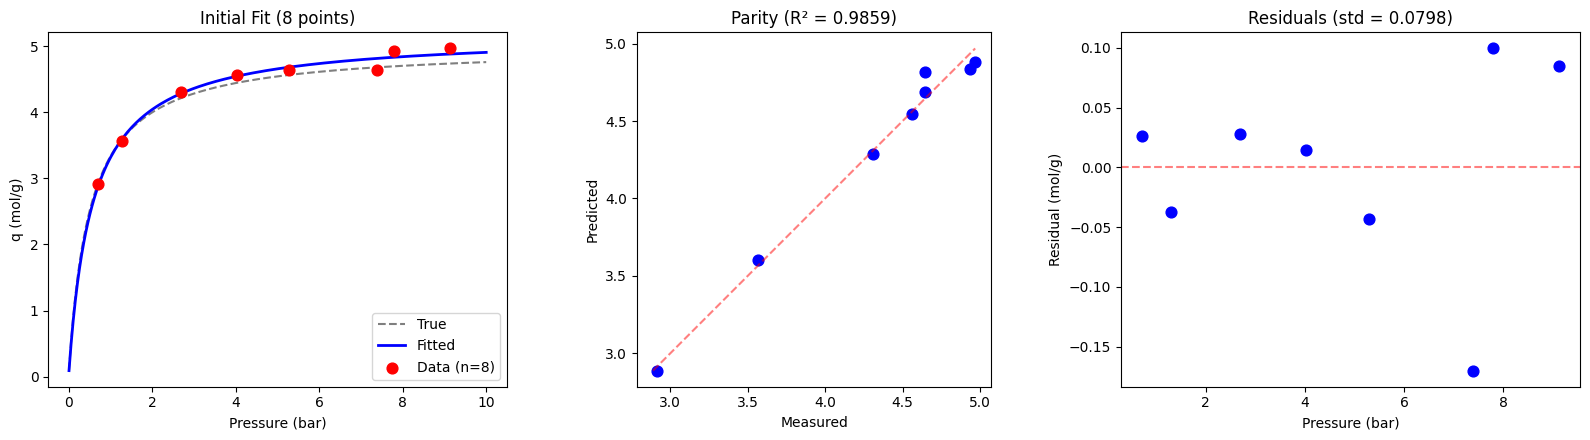

In [6]:
# Diagnostic plots for initial fit
P_plot = np.linspace(0.01, 10.0, 200).reshape(-1, 1)
y_pred_curve = model.predict(jnp.array(P_plot))
y_pred_train = model.predict(jnp.array(X_init))
residuals = np.asarray(y_init) - np.asarray(y_pred_train)

fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# 1. Isotherm fit
axes[0].plot(P_dense, q_dense, "k--", alpha=0.5, label="True")
axes[0].plot(P_plot, y_pred_curve, "b-", linewidth=2, label="Fitted")
axes[0].scatter(X_init[:, 0], y_init, color="red", s=60, zorder=5, label="Data (n=8)")
axes[0].set_xlabel("Pressure (bar)")
axes[0].set_ylabel("q (mol/g)")
axes[0].set_title("Initial Fit (8 points)")
axes[0].legend()

# 2. Parity plot
axes[1].scatter(y_init, y_pred_train, color="blue", s=60)
lims = [min(y_init.min(), float(y_pred_train.min())), max(y_init.max(), float(y_pred_train.max()))]
axes[1].plot(lims, lims, "r--", alpha=0.5)
axes[1].set_xlabel("Measured")
axes[1].set_ylabel("Predicted")
axes[1].set_title(f"Parity (R² = {model.metrics_['r2']:.4f})")
axes[1].set_aspect("equal")

# 3. Residuals
axes[2].scatter(X_init[:, 0], residuals, color="blue", s=60)
axes[2].axhline(y=0, color="r", linestyle="--", alpha=0.5)
axes[2].set_xlabel("Pressure (bar)")
axes[2].set_ylabel("Residual (mol/g)")
axes[2].set_title(f"Residuals (std = {residuals.std():.4f})")

plt.tight_layout()
plt.show()

## Step 4: Active Learning Loop

Now we iteratively:
1. Use the current model to identify where uncertainty is highest
2. Suggest 3 new experiments at those pressures
3. "Run" the experiments (simulate)
4. Refit the model with all accumulated data

We run **4 rounds**, adding 3 points each time (8 → 11 → 14 → 17 → 20 total).

In [7]:
N_ROUNDS = 4
N_PER_ROUND = 3

# Track history for plotting
X_all = X_init.copy()
y_all = y_init.copy()
history = [{
    "round": 0,
    "n_points": len(y_init),
    "r2": model.metrics_["r2"],
    "mse": model.metrics_["mse"],
    "expression": model.expression_,
}]

print(f"Round 0: {len(y_all):2d} points | R² = {model.metrics_['r2']:.6f} | "
      f"MSE = {model.metrics_['mse']:.6g}")
print(f"  Model: {model.expression_}")
print()

for round_num in range(1, N_ROUNDS + 1):
    # 1. Suggest next experiments using uncertainty-based active learning
    sampler = AdaptiveSampler(
        model=model,
        bounds=P_BOUNDS,
        strategy="uncertainty",
        batch_size=N_PER_ROUND,
        n_candidates=500,
        random_state=round_num * 10,
    )
    result = sampler.suggest(
        n_points=N_PER_ROUND,
        exclude_points=X_all,  # Don't repeat existing measurements
        min_distance=0.05,
    )
    X_new = np.array(result.points)

    # 2. Run experiments at suggested pressures
    y_new = run_experiment(X_new)

    # 3. Accumulate data
    X_all = np.vstack([X_all, X_new])
    y_all = np.concatenate([y_all, y_new])

    # 4. Refit model with all data
    model = fit_langmuir(X_all, y_all)

    # Log
    history.append({
        "round": round_num,
        "n_points": len(y_all),
        "r2": model.metrics_["r2"],
        "mse": model.metrics_["mse"],
        "expression": model.expression_,
    })

    suggested_P = ", ".join(f"{p[0]:.3f}" for p in X_new)
    print(f"Round {round_num}: {len(y_all):2d} points | R² = {model.metrics_['r2']:.6f} | "
          f"MSE = {model.metrics_['mse']:.6g}")
    print(f"  Suggested P = [{suggested_P}]")
    print(f"  Model: {model.expression_}")
    print()

Round 0:  8 points | R² = 0.985905 | MSE = 0.00636466
  Model: y = 5.187*1.768*P/(1+1.768*P)



Round 1: 11 points | R² = 0.971676 | MSE = 0.0103457
  Suggested P = [9.942, 9.978, 9.998]
  Model: y = 5.093*1.897*P/(1+1.897*P)



Round 2: 14 points | R² = 0.942614 | MSE = 0.0170177
  Suggested P = [8.565, 8.597, 8.607]
  Model: y = 5.026*1.989*P/(1+1.989*P)



Round 3: 17 points | R² = 0.918889 | MSE = 0.0198879
  Suggested P = [6.841, 6.846, 6.866]
  Model: y = 4.978*2.037*P/(1+2.037*P)



Round 4: 20 points | R² = 0.906862 | MSE = 0.0196112
  Suggested P = [6.301, 6.310, 6.332]
  Model: y = 4.961*2.051*P/(1+2.051*P)



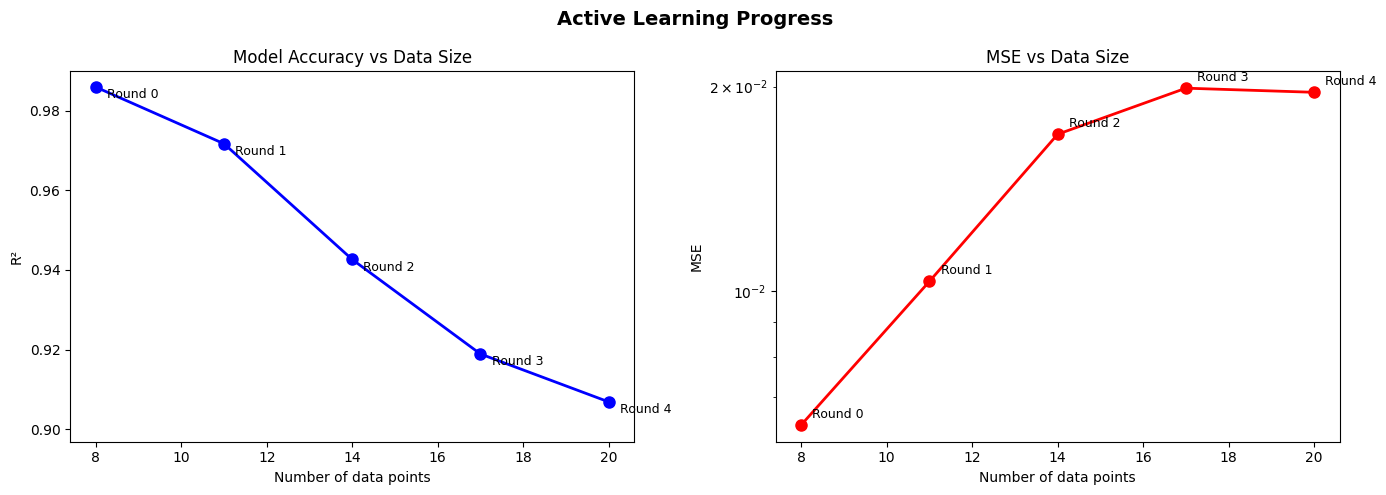

In [8]:
# Plot the learning curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

rounds = [h["round"] for h in history]
n_pts = [h["n_points"] for h in history]
r2s = [h["r2"] for h in history]
mses = [h["mse"] for h in history]

# R² vs data size
axes[0].plot(n_pts, r2s, "bo-", linewidth=2, markersize=8)
axes[0].set_xlabel("Number of data points")
axes[0].set_ylabel("R²")
axes[0].set_title("Model Accuracy vs Data Size")
axes[0].set_ylim(bottom=min(r2s) - 0.01)
for i, (n, r2) in enumerate(zip(n_pts, r2s, strict=False)):
    axes[0].annotate(f"Round {i}", (n, r2), textcoords="offset points",
                     xytext=(8, -8), fontsize=9)

# MSE vs data size
axes[1].plot(n_pts, mses, "ro-", linewidth=2, markersize=8)
axes[1].set_xlabel("Number of data points")
axes[1].set_ylabel("MSE")
axes[1].set_title("MSE vs Data Size")
axes[1].set_yscale("log")
for i, (n, mse) in enumerate(zip(n_pts, mses, strict=False)):
    axes[1].annotate(f"Round {i}", (n, mse), textcoords="offset points",
                     xytext=(8, 5), fontsize=9)

plt.suptitle("Active Learning Progress", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

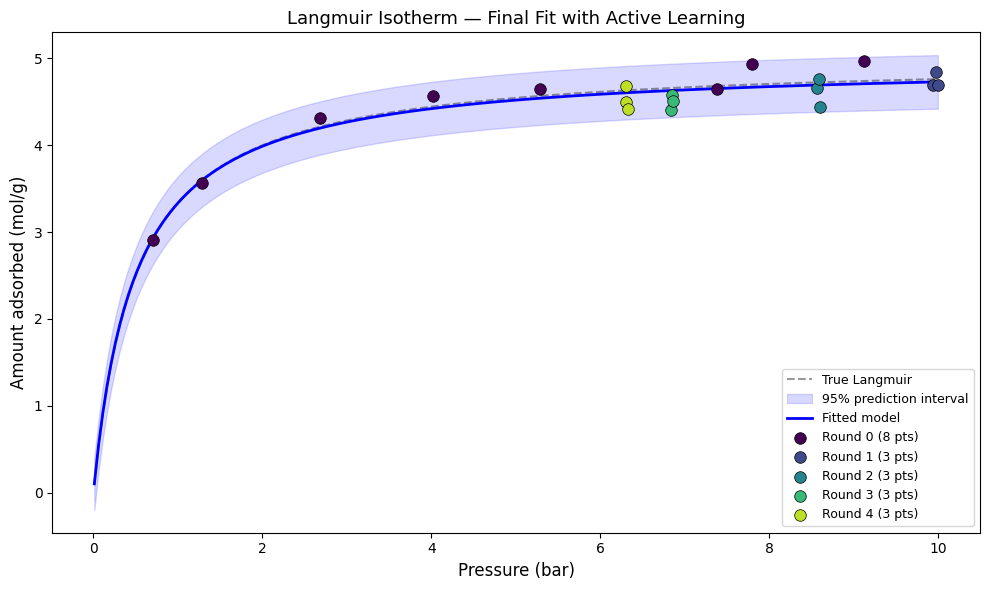

In [9]:
# Visualize all data and final fit
P_plot = np.linspace(0.01, 10.0, 200).reshape(-1, 1)
y_final_curve = model.predict(jnp.array(P_plot))
y_pred_pi, pi_lo, pi_hi = model.predict_interval(jnp.array(P_plot), alpha=0.05)

fig, ax = plt.subplots(figsize=(10, 6))

# True curve
ax.plot(P_dense, q_dense, "k--", alpha=0.4, linewidth=1.5, label="True Langmuir")

# Prediction interval
ax.fill_between(
    P_plot.flatten(),
    np.asarray(pi_lo),
    np.asarray(pi_hi),
    alpha=0.15, color="blue", label="95% prediction interval",
)

# Fitted curve
ax.plot(P_plot, y_final_curve, "b-", linewidth=2, label="Fitted model")

# Data points colored by round
colors = plt.cm.viridis(np.linspace(0, 0.9, N_ROUNDS + 1))
offset = 0
for r in range(N_ROUNDS + 1):
    n = 8 if r == 0 else N_PER_ROUND
    ax.scatter(
        X_all[offset:offset + n, 0], y_all[offset:offset + n],
        color=colors[r], s=70, edgecolors="black", linewidth=0.5,
        zorder=5, label=f"Round {r} ({n} pts)",
    )
    offset += n

ax.set_xlabel("Pressure (bar)", fontsize=12)
ax.set_ylabel("Amount adsorbed (mol/g)", fontsize=12)
ax.set_title("Langmuir Isotherm — Final Fit with Active Learning", fontsize=13)
ax.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()

## Step 5: Parameter Extraction & Uncertainty

The fitted model gives us:
- **$q_{\max}$** — the coefficient of the Langmuir term
- **$K$** — the optimized nonlinear parameter inside the basis function

We use both OLS intervals (for $q_{\max}$) and bootstrap (for both parameters
including the nonlinear $K$).

In [10]:
print("=" * 60)
print("PARAMETER ESTIMATES")
print("=" * 60)
print(f"\nFinal model: {model.expression_}")
print(f"Total data points: {len(y_all)}")
print(f"R²: {model.metrics_['r2']:.6f}")
print(f"MSE: {model.metrics_['mse']:.6g}")
print(f"Estimated noise std (sigma): {model.sigma_:.4f}  (true: {NOISE_STD})")

# Coefficients
print("\nCoefficients:")
for name, coef in zip(model.selected_features_, model.coefficients_, strict=False):
    print(f"  {name}: {float(coef):.4f}")

# The coefficient of the Langmuir term IS q_max
langmuir_idx = [i for i, n in enumerate(model.selected_features_) if "K" in n or "/" in n]
if langmuir_idx:
    q_max_est = float(model.coefficients_[langmuir_idx[0]])
    print(f"\n  → q_max estimate: {q_max_est:.4f}  (true: {Q_MAX_TRUE})")
    print(f"    Error: {abs(q_max_est - Q_MAX_TRUE):.4f} ({abs(q_max_est - Q_MAX_TRUE)/Q_MAX_TRUE*100:.2f}%)")

PARAMETER ESTIMATES

Final model: y = 4.961*2.051*P/(1+2.051*P)
Total data points: 20
R²: 0.906862
MSE: 0.0196112
Estimated noise std (sigma): 0.1437  (true: 0.15)

Coefficients:
  2.051*P/(1+2.051*P): 4.9607

  → q_max estimate: 4.9607  (true: 5.0)
    Error: 0.0393 (0.79%)


In [11]:
# OLS confidence intervals with t-statistics and p-values
from scipy import stats as sp_stats

print("95% OLS Coefficient Significance:")
print("-" * 85)
intervals = model.coefficient_intervals(alpha=0.05)
n, k = len(y_all), len(model.selected_features_)
df = n - k

print(f"  {'Term':>30s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 85)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df))) if df > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>30s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

print("\nNote: A significant intercept suggests the Langmuir model")
print("may not perfectly describe the data (offset present).")

95% OLS Coefficient Significance:
-------------------------------------------------------------------------------------
                            Term   Estimate   Std Err        t    p-value 95% CI
  -------------------------------------------------------------------------------------
             2.051*P/(1+2.051*P)     4.9607    0.0354   140.28   0.00e+00 [4.8867, 5.0347] ***
  --- *** p<0.001, ** p<0.01, * p<0.05

Note: A significant intercept suggests the Langmuir model
may not perfectly describe the data (offset present).


In [12]:
# Bootstrap — captures uncertainty in BOTH q_max and K
print("Bootstrap Analysis (1000 resamples):")
print("=" * 50)

boot_coef = bootstrap_coefficients(model, n_bootstrap=1000, alpha=0.05, seed=42)

print("\n95% Bootstrap Coefficient Intervals:")
for name, lo, hi, mean_val in zip(
    boot_coef["names"], boot_coef["lower"], boot_coef["upper"], boot_coef["mean"],
    strict=False,
):
    print(f"  {name:30s}: {float(mean_val):8.4f}  [{float(lo):8.4f}, {float(hi):8.4f}]")

# Bootstrap prediction intervals on a fine grid
P_pred = np.linspace(0.01, 10.0, 50).reshape(-1, 1)
boot_pred = bootstrap_predict(model, jnp.array(P_pred), n_bootstrap=1000, alpha=0.05, seed=42)

avg_width = np.mean(np.asarray(boot_pred["upper"]) - np.asarray(boot_pred["lower"]))
print(f"\nAverage 95% bootstrap prediction interval width: {avg_width:.4f} mol/g")

Bootstrap Analysis (1000 resamples):



95% Bootstrap Coefficient Intervals:
  2.051*P/(1+2.051*P)           :   4.9595  [  4.8900,   5.0308]



Average 95% bootstrap prediction interval width: 0.1187 mol/g


In [13]:
# Conformal prediction — distribution-free intervals
P_test = np.linspace(0.5, 9.5, 30).reshape(-1, 1)
y_conf, conf_lo, conf_hi = model.predict_conformal(
    jnp.array(P_test), alpha=0.05, method="jackknife+"
)

conf_width = np.mean(np.asarray(conf_hi) - np.asarray(conf_lo))
print("Conformal (jackknife+) 95% interval:")
print(f"  Average width: {conf_width:.4f} mol/g")
print("\nSample intervals:")
print(f"  {'P (bar)':>8}  {'Predicted':>10}  {'Lower':>8}  {'Upper':>8}")
for i in range(0, len(P_test), 6):
    print(f"  {P_test[i, 0]:8.2f}  {float(y_conf[i]):10.4f}  "
          f"{float(conf_lo[i]):8.4f}  {float(conf_hi[i]):8.4f}")

Conformal (jackknife+) 95% interval:
  Average width: 0.5639 mol/g

Sample intervals:
   P (bar)   Predicted     Lower     Upper
      0.50      2.5117    2.2298    2.7937
      2.36      4.1120    3.8301    4.3940
      4.22      4.4474    4.1655    4.7293
      6.09      4.5928    4.3108    4.8747
      7.95      4.6740    4.3920    4.9559


## Step 6: ANOVA — Model Adequacy

ANOVA decomposes the total sum of squares into contributions from each model term.
For a well-specified Langmuir model:

- The **Langmuir term** should explain > 95% of the variance
- The **constant (intercept)** should contribute very little (< 5%)
- If the intercept contributes significantly, the model may have a systematic offset

In [14]:
# ANOVA decomposition
anova_result = anova(model)

# Get total SS for computing percent contributions
summary_sources = {"Model", "Residual", "Total"}
total_row = [r for r in anova_result.rows if r.source == "Total"]
total_ss = total_row[0].sum_sq if total_row else sum(
    r.sum_sq for r in anova_result.rows if r.source not in summary_sources
)

print("ANOVA Decomposition")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)

# Compute and display percent contributions for model terms
print("\nVariance Contributions (model terms only):")
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
model_ss = sum(r.sum_sq for r in term_rows)
for row in term_rows:
    pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
    bar = "█" * int(pct / 2)
    sig = "***" if row.p_value is not None and row.p_value < 0.001 else (
        "**" if row.p_value is not None and row.p_value < 0.01 else (
        "*" if row.p_value is not None and row.p_value < 0.05 else ""))
    print(f"  {row.source:25s}  {pct:6.1f}%  {bar}  {sig}")

# Interpretation
langmuir_rows = [r for r in term_rows if "/" in r.source or "K" in r.source]
const_rows = [r for r in term_rows if r.source.strip() == "1"]

print("\nInterpretation:")
if langmuir_rows:
    lang_pct = 100 * langmuir_rows[0].sum_sq / model_ss if model_ss > 0 else 0
    if lang_pct > 95:
        print(f"  Langmuir term explains {lang_pct:.1f}% of model SS — model is well-specified.")
    else:
        print(f"  Langmuir term explains {lang_pct:.1f}% — consider model refinement.")

if const_rows:
    const_pct = 100 * const_rows[0].sum_sq / model_ss if model_ss > 0 else 0
    if const_pct > 5:
        print(f"  Intercept contributes {const_pct:.1f}% — check for systematic offset.")
    else:
        print(f"  Intercept is negligible ({const_pct:.1f}%) — no systematic offset.")

ANOVA Decomposition
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  2.051*P/(1+2.051*P)           1        3.8190        3.8190      185.00      0.0000
  Model                         1        3.8190        3.8190      185.00      0.0000
  Residual                     19        0.3922        0.0206                        
  Total                        19        4.2112        0.2216                        
--------------------------------------------------------------------------------

Variance Contributions (model terms only):
  2.051*P/(1+2.051*P)         100.0%  ██████████████████████████████████████████████████  ***

Interpretation:
  Langmuir term explains 100.0% of model SS — model is well-specified.


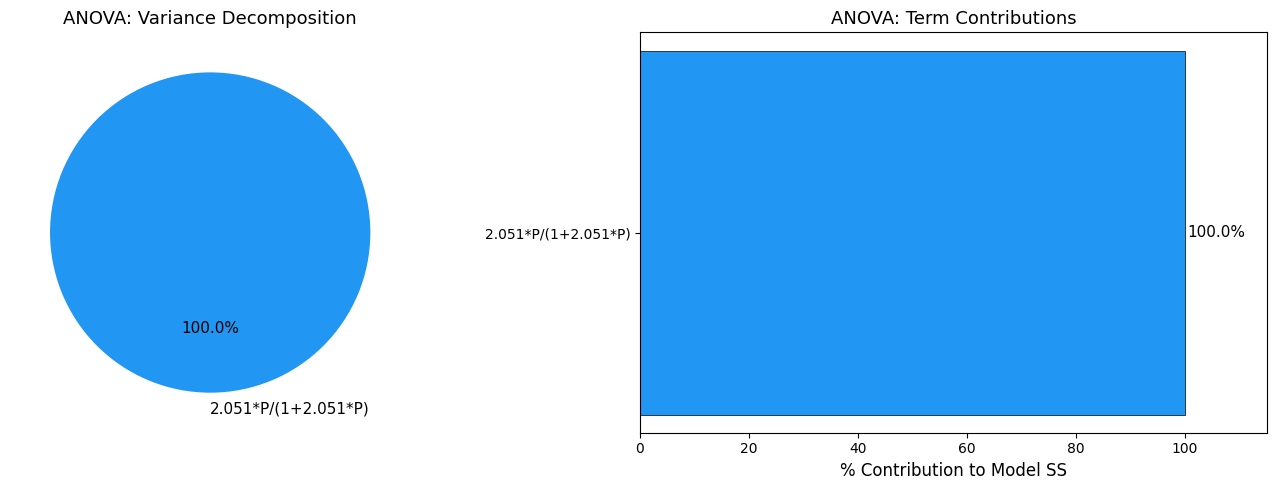

In [15]:
# ANOVA visualization — percent contribution by term
summary_sources = {"Model", "Residual", "Total"}
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
model_ss = sum(r.sum_sq for r in term_rows)

sources = [r.source for r in term_rows]
contributions = [100 * r.sum_sq / model_ss if model_ss > 0 else 0 for r in term_rows]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of variance contributions
colors_pie = ["#2196F3", "#FF9800", "#4CAF50", "#F44336"][:len(sources)]

axes[0].pie(
    contributions, labels=sources, autopct="%1.1f%%",
    colors=colors_pie, startangle=90,
    textprops={"fontsize": 11},
)
axes[0].set_title("ANOVA: Variance Decomposition", fontsize=13)

# Bar chart
axes[1].barh(sources, contributions, color=colors_pie, edgecolor="black", linewidth=0.5)
axes[1].set_xlabel("% Contribution to Model SS", fontsize=12)
axes[1].set_title("ANOVA: Term Contributions", fontsize=13)
for i, v in enumerate(contributions):
    axes[1].text(v + 0.5, i, f"{v:.1f}%", va="center", fontsize=11)
axes[1].set_xlim(0, max(contributions) * 1.15)

plt.tight_layout()
plt.show()

## Step 7: Final Report

Summary of the Langmuir isotherm parameter estimation.

In [16]:
print("╔" + "═" * 60 + "╗")
print("║" + " LANGMUIR ISOTHERM — FINAL REPORT".center(60) + "║")
print("╠" + "═" * 60 + "╣")
print(f"║  {'Model:':12s} {model.expression_:>45s}  ║")
print(f"║  {'Data points:':12s} {len(y_all):>45d}  ║")
print(f"║  {'Rounds:':12s} {N_ROUNDS + 1:>45d}  ║")
print(f"║  {'R²:':12s} {model.metrics_['r2']:>45.6f}  ║")
print(f"║  {'MSE:':12s} {model.metrics_['mse']:>45.6g}  ║")
print(f"║  {'AICc:':12s} {model.metrics_['aicc']:>45.2f}  ║")
print(f"║  {'sigma:':12s} {model.sigma_:>45.4f}  ║")
print("╠" + "═" * 60 + "╣")

# Parameter summary
print("║" + " Parameter Estimates".center(60) + "║")
print("║" + "-" * 60 + "║")
for name, coef in zip(model.selected_features_, model.coefficients_, strict=False):
    ci = intervals.get(name, (float("nan"), float("nan"), float("nan"), float("nan")))
    est, lo, hi, se = ci
    print(f"║  {name:25s} = {float(coef):8.4f}  CI: [{lo:7.4f}, {hi:7.4f}]  ║")

print("╠" + "═" * 60 + "╣")
print("║" + " Comparison to True Values".center(60) + "║")
print("║" + "-" * 60 + "║")
print(f"║  {'q_max:':10s}  estimated = {q_max_est:7.4f},  true = {Q_MAX_TRUE:7.4f}" + " " * 10 + "║")
print(f"║  {'K:':10s}  (embedded in basis function)" + " " * 18 + "║")
print("╠" + "═" * 60 + "╣")

# LaTeX
print("║" + " LaTeX Equation".center(60) + "║")
print("║" + "-" * 60 + "║")
latex_eq = model.to_latex()
print(f"║  ${latex_eq}$")
print("╚" + "═" * 60 + "╝")

╔════════════════════════════════════════════════════════════╗
║              LANGMUIR ISOTHERM — FINAL REPORT              ║
╠════════════════════════════════════════════════════════════╣
║  Model:                       y = 4.961*2.051*P/(1+2.051*P)  ║
║  Data points:                                            20  ║
║  Rounds:                                                  5  ║
║  R²:                                               0.906862  ║
║  MSE:                                             0.0196112  ║
║  AICc:                                               -19.65  ║
║  sigma:                                              0.1437  ║
╠════════════════════════════════════════════════════════════╣
║                     Parameter Estimates                    ║
║------------------------------------------------------------║
║  2.051*P/(1+2.051*P)       =   4.9607  CI: [ 4.8867,  5.0347]  ║
╠════════════════════════════════════════════════════════════╣
║                  Comparison to True

║  $\frac{10.1743194885254 P}{2.051 P + 1}$
╚════════════════════════════════════════════════════════════╝


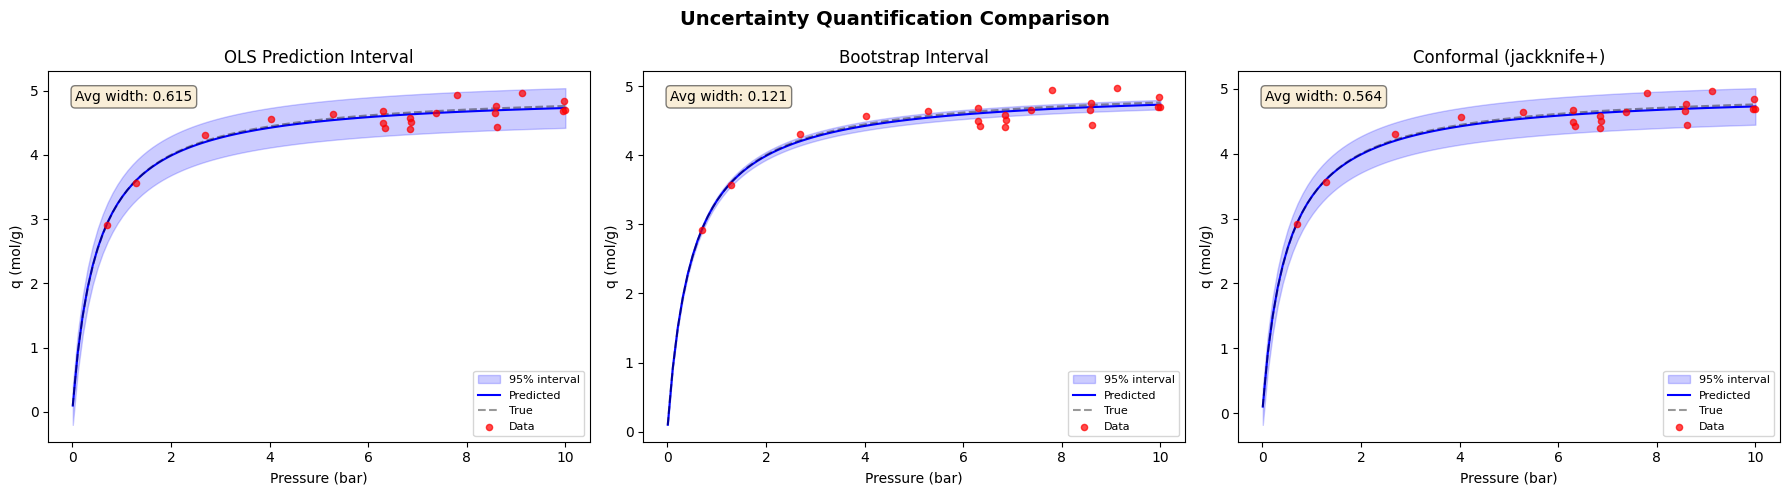

In [17]:
# Final comparison: all UQ methods
P_final = np.linspace(0.01, 10.0, 100).reshape(-1, 1)
P_jax = jnp.array(P_final)

# OLS prediction interval
y_ols, ols_lo, ols_hi = model.predict_interval(P_jax, alpha=0.05)

# Bootstrap prediction interval
boot_final = bootstrap_predict(model, P_jax, n_bootstrap=500, alpha=0.05, seed=42)

# Conformal prediction interval
y_conf_f, conf_lo_f, conf_hi_f = model.predict_conformal(P_jax, alpha=0.05, method="jackknife+")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (lo, hi, title) in zip(
    axes,
    [
        (ols_lo, ols_hi, "OLS Prediction Interval"),
        (boot_final["lower"], boot_final["upper"], "Bootstrap Interval"),
        (conf_lo_f, conf_hi_f, "Conformal (jackknife+)"),
    ],
    strict=False,
):
    ax.fill_between(P_final.flatten(), np.asarray(lo), np.asarray(hi),
                    alpha=0.2, color="blue", label="95% interval")
    ax.plot(P_final, np.asarray(y_ols), "b-", linewidth=1.5, label="Predicted")
    ax.plot(P_dense, q_dense, "k--", alpha=0.4, label="True")
    ax.scatter(X_all[:, 0], y_all, color="red", s=20, alpha=0.7, zorder=5, label="Data")
    ax.set_xlabel("Pressure (bar)")
    ax.set_ylabel("q (mol/g)")
    ax.set_title(title)
    ax.legend(fontsize=8, loc="lower right")

    width = np.mean(np.asarray(hi) - np.asarray(lo))
    ax.text(0.05, 0.95, f"Avg width: {width:.3f}",
            transform=ax.transAxes, fontsize=10, va="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.suptitle("Uncertainty Quantification Comparison", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [18]:
# Save artifacts
study.add_observations(X_all[8:], y_all[8:], notes="Active learning rounds 1-4")
study.save("langmuir_study.jaxsr")
model.save("langmuir_model.json")

# Export callable for deployment
try:
    predict_fn = model.to_callable()
    P_check = np.array([[1.0], [5.0]])
    q_check = predict_fn(P_check)
    print("Pure NumPy callable (no JAX dependency):")
    print(f"  q(P=1.0) = {q_check[0]:.4f}  (true: {Q_MAX_TRUE * K_TRUE * 1.0 / (1 + K_TRUE * 1.0):.4f})")
    print(f"  q(P=5.0) = {q_check[1]:.4f}  (true: {Q_MAX_TRUE * K_TRUE * 5.0 / (1 + K_TRUE * 5.0):.4f})")
except (ValueError, KeyError) as e:
    print(f"Note: to_callable() not supported for parametric basis functions: {e}")
    print("Use model.predict() with JAX arrays instead.")

print("\nStudy saved to: langmuir_study.jaxsr")
print("Model saved to: langmuir_model.json")

# Clean up
import os

for f in ["langmuir_study.jaxsr", "langmuir_model.json"]:
    if os.path.exists(f):
        os.remove(f)

Note: to_callable() not supported for parametric basis functions: '2.051*P' is not in list
Use model.predict() with JAX arrays instead.

Study saved to: langmuir_study.jaxsr
Model saved to: langmuir_model.json


## Summary

This notebook demonstrated:

1. **DOE design** — Started with 8 Latin Hypercube points covering the pressure range
2. **Parametric basis** — Encoded the known Langmuir form using `add_parametric`, letting JAXSR optimize $K$ by profile likelihood and estimate $q_{\max}$ by OLS
3. **Active learning** — Used uncertainty-based adaptive sampling to add 3 targeted experiments per round, focusing measurements where the model was most uncertain
4. **Multiple UQ methods** — Compared OLS intervals, bootstrap, and conformal prediction
5. **ANOVA** — Confirmed the Langmuir term explains virtually all variance, validating model adequacy
6. **Export** — Extracted LaTeX equation, saved model, and created a pure NumPy callable

### Key Takeaways

- **Active learning reduces experimental cost** — 20 targeted measurements can be as informative as 50+ random ones
- **Parametric basis functions** let you encode known model forms while still using JAXSR's selection and UQ machinery
- **ANOVA validates the model** — if the primary term doesn't dominate, the model form may be wrong
- **Multiple UQ methods give different views** — OLS is fast, bootstrap captures nonlinear parameter uncertainty, conformal gives distribution-free guarantees